## FNHW05
### 1，先在训练集上完成模型训练，再在测试集上测试模型的性能（必做）

In [1]:
# %load Logistic Regression.py
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [2]:
def Missingrate_Column(df, col):
    '''
    统计某个字段中的缺失率
    :param df:
    :param col:
    :return:
    '''
    missing_records = df[col].map(lambda x: int(x!=x))#int(True) = 1
    return missing_records.mean()

In [3]:
def MakeupM_Missing(df,col, makeup_value):
    '''
    缺失值填补：把df的col列中的缺失值用makeup_value填补
    :param df:
    :param col:
    :return:
    '''
    raw_values = list(df[col])
    missing_position = [i for i in range(len(raw_values)) if raw_values[i] != raw_values[i]]
    for i in missing_position:
        raw_values[i] = makeup_value
    return raw_values

In [4]:
def Avg_Calc(numerator, denominator):
    '''
    计算比率
    '''
    if denominator == 0:
        return 0
    else:
        return numerator/denominator

In [5]:
def Outlier_Effect(df,col,target,percentiles=[1,99]):
    '''
    计算异常值对于欺诈概率的影响
    :param df:
    :param col:
    :param target:
    :return:
    '''
    lower, upper = np.percentile(df[col],percentiles[0]),np.percentile(df[col],percentiles[1])
    lower_sample, middle_sample, upper_sample = df[df[col]<lower], df[(df[col]>=lower)&(df[col]<=upper)], df[df[col]>upper]
    lower_fraud, middle_fraud, upper_fraud = lower_sample[target].mean(), middle_sample[target].mean(), upper_sample[target].mean()
    lower_logodds, upper_logodds = np.log(lower_fraud/middle_fraud),np.log(upper_fraud/middle_fraud)
    return [lower_logodds, upper_logodds]

In [6]:
def Zero_Score_Normalization(df,col,percentiles=[1,99]):
    '''
    均值-标准差归一化，返回归一化后的列，最小值，最大值，均值，标准差
    :param df:
    :param col:
    :param target:
    :return:
    '''
    lower, upper = np.percentile(df[col], percentiles[0]), np.percentile(df[col], percentiles[1])
    new_col = df[col].map(lambda x: min(max(x, lower),upper))
    mu,sigma = new_col.mean(), np.sqrt(new_col.var())
    new_var = new_col.map(lambda x: (x-mu)/sigma)
    return {'new_var':new_var,'lower':lower,'upper':upper,'mu':mu, 'sigma':sigma}

In [7]:
##########################################
####  1，读取数据，划分成训练集与测试集  #####
##########################################
raw_data = pd.read_csv('anti_fraud_data.csv', header = 0)
train_data, test_data = model_selection.train_test_split(raw_data, test_size=0.3)

In [9]:
train_data.head()

,ID,is_email_acct,certificationtype,registered_channels,sex,age,registered_days,area1_danger,area4_danger,is_area3_eqaul_area4,...,10m_pay_times,12h_pay_times,1d_pay_times,1h_pay_times,30m_pay_times,10m_Sum_pay_amount,12h_Sum_pay_amount,1d_Sum_pay_amount,1h_Sum_pay_amount,flag
34679,34679,0.0,3,PC,2.0,45,472,5.0,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
30551,30551,0.0,2,SDK,2.0,28,981,5.0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
7462,7462,NaN,4,NaN,NaN,0,0,5.0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
29711,29711,0.0,3,PC,2.0,31,651,5.0,1,1,...,NaN,2.0,2.0,NaN,NaN,NaN,459800.0,459800,NaN,0
4180,4180,NaN,4,NaN,NaN,0,0,5.0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [29]:
train_data.dtypes.value_counts()

int64      44
float64    33
object      3
dtype: int64

In [10]:
train_data.shape

(32884, 96)

In [27]:
train_data['flag'].value_counts()

0    32497
1      387
Name: flag, dtype: int64

In [11]:
all_columns = list(train_data.columns)
all_columns.remove('ID')
all_columns.remove('flag')

#查看整体的欺诈概率
print("the overall fraud rate is {0:2.4f}%".format(train_data['flag'].mean()*100))

the overall fraud rate is 1.1769%


In [12]:
##############################
####  2，缺失值分析与补缺  #####
##############################
#先检查是否有常数型字段
fix_value_check = {col: len(set(train_data[col])) for col in all_columns}
fix_value_check

{'is_email_acct': 4034,
 'certificationtype': 4,
 'registered_channels': 8,
 'sex': 9664,
 'age': 70,
 'registered_days': 2092,
 'area1_danger': 12,
 'area4_danger': 5,
 'is_area3_eqaul_area4': 2,
 'is_area3_equal_area6': 2,
 'is_area4_equal_area6': 2,
 'is_area5_equal_area3': 1,
 'is_area5_equal_area4': 1,
 'is_area5_equal_area6': 1,
 'is_area1_equal_area2': 1,
 'is_area7_equal_area3': 2,
 'is_area7_equal_area4': 2,
 'is_area7_equal_area6': 2,
 'is_area7_equal_area5': 1,
 'is_area2_equal_area3': 2,
 'is_area2_equal_area4': 2,
 'is_area2_equal_area6': 2,
 'is_area2_equal_area5': 1,
 'area4_danger.1': 5,
 'area2_danger': 5,
 'area10_danger': 1,
 'ip_desc_danger': 32884,
 'is_area1_equal_area11': 1,
 'is_area10_equal_area8': 2,
 'is_area10_equal_area9': 2,
 'is_area2_equal_area8': 2,
 'is_area2_equal_area9': 2,
 'is_area8_equal_area3': 2,
 'is_area8_equal_area4': 2,
 'is_area8_equal_area6': 2,
 'is_area8_equal_area5': 1,
 'is_area8_equal_area9': 2,
 'is_area9_equal_area3': 2,
 'is_area9_

In [13]:
fix_value_vars = [var for var in list(fix_value_check.keys()) if fix_value_check[var] == 1]
for var in fix_value_vars:
    all_columns.remove(var)
    print('{}为常数型字段，已移除'.format(var))
    del train_data[var]
    del test_data[var]

is_area5_equal_area3为常数型字段，已移除
is_area5_equal_area4为常数型字段，已移除
is_area5_equal_area6为常数型字段，已移除
is_area1_equal_area2为常数型字段，已移除
is_area7_equal_area5为常数型字段，已移除
is_area2_equal_area5为常数型字段，已移除
area10_danger为常数型字段，已移除
is_area1_equal_area11为常数型字段，已移除
is_area8_equal_area5为常数型字段，已移除
is_area9_equal_area5为常数型字段，已移除
30d_AcctPerDevice为常数型字段，已移除
30d_AcctPerIP为常数型字段，已移除
1d_Max_pay_amount为常数型字段，已移除
12h_Min_pay_amount为常数型字段，已移除
1d_Min_pay_amount为常数型字段，已移除


In [18]:
#查看每个字段的缺失率
column_missingrate = {col: Missingrate_Column(train_data, col) for col in all_columns}
column_missingrate

{'is_email_acct': 0.12261282082471718,
 'certificationtype': 0.0,
 'registered_channels': 0.37282569030531565,
 'sex': 0.2938207030774845,
 'age': 0.0,
 'registered_days': 0.0,
 'area1_danger': 0.00033450918379759155,
 'area4_danger': 0.0,
 'is_area3_eqaul_area4': 0.0,
 'is_area3_equal_area6': 0.0,
 'is_area4_equal_area6': 0.0,
 'is_area7_equal_area3': 0.0,
 'is_area7_equal_area4': 0.0,
 'is_area7_equal_area6': 0.0,
 'is_area2_equal_area3': 0.0,
 'is_area2_equal_area4': 0.0,
 'is_area2_equal_area6': 0.0,
 'area4_danger.1': 0.0,
 'area2_danger': 0.0,
 'ip_desc_danger': 1.0,
 'is_area10_equal_area8': 0.0,
 'is_area10_equal_area9': 0.0,
 'is_area2_equal_area8': 0.0,
 'is_area2_equal_area9': 0.0,
 'is_area8_equal_area3': 0.0,
 'is_area8_equal_area4': 0.0,
 'is_area8_equal_area6': 0.0,
 'is_area8_equal_area9': 0.0,
 'is_area9_equal_area3': 0.0,
 'is_area9_equal_area4': 0.0,
 'is_area9_equal_area6': 0.0,
 'area8_danger': 0.29674005595426345,
 'area11_danger': 0.0,
 'area6_danger': 0.0,
 'pay

In [20]:
column_MR_df = pd.DataFrame.from_dict(column_missingrate, orient='index')
column_MR_df

,0
is_email_acct,0.122613
certificationtype,0.000000
registered_channels,0.372826
sex,0.293821
age,0.000000
registered_days,0.000000
area1_danger,0.000335
area4_danger,0.000000
is_area3_eqaul_area4,0.000000
is_area3_equal_area6,0.000000


In [21]:
column_MR_df.columns = ['missing_rate']
column_MR_df_sorted = column_MR_df.sort_values(by='missing_rate', ascending=False)
column_MR_df_sorted

,missing_rate
ip_desc_danger,1.000000
1h_release_bank_cnt,0.975094
12h_release_bank_cnt,0.962930
24h_release_bank_cnt,0.959768
10m_pay_times,0.887818
10m_Sum_pay_amount,0.887727
30m_pay_times,0.859628
30m_Sum_pay_amount,0.859537
1h_pay_times,0.843784
1h_Sum_pay_amount,0.843754


Text(0.5,1,'Columns Missing Rate')

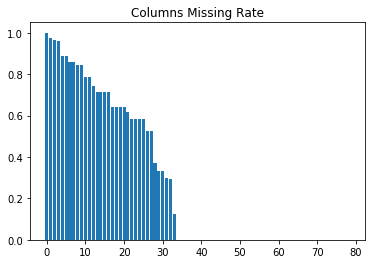

In [22]:
plt.bar(x=range(column_MR_df_sorted.shape[0]), height=column_MR_df_sorted.missing_rate)
plt.title('Columns Missing Rate')

In [23]:
#由于变量ip_desc_danger在训练集中全部缺失，故将其删去。
all_columns.remove('ip_desc_danger')
del train_data['ip_desc_danger']
del test_data['ip_desc_danger']
column_MR_df_sorted = column_MR_df_sorted.drop(index=['ip_desc_danger'])
columns_with_missing = column_MR_df_sorted[column_MR_df_sorted.missing_rate > 0].index

In [24]:
#查看缺失值与非缺失值对欺诈的影响
check_missingrate = {}
for col in columns_with_missing:
    temp_df = train_data[[col,'flag']]
    temp_df[col] = temp_df.apply(lambda x: int(x[col] != x[col]),axis=1)
    a = temp_df['flag'].groupby(temp_df[col]).mean()#统计一下是否含有缺失值的字段 中 目标变量分别所占的比例。如果比例差不多，说明缺失值对目标值无影响，否则有影响。
    check_missingrate[col] = [a.ix[0], a.ix[1]]

/home/ian/installed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ian/installed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [25]:
check_missingrate

{'1h_release_bank_cnt': [0.019536019536019536, 0.011570247933884297],
 '12h_release_bank_cnt': [0.022149302707136997, 0.011369019422074847],
 '24h_release_bank_cnt': [0.021164021164021163, 0.011374798010202466],
 '10m_pay_times': [0.00433721875847113, 0.012707655420448707],
 '10m_Sum_pay_amount': [0.004333694474539545, 0.012708961359276514],
 '30m_pay_times': [0.006715771230502599, 0.012593745578038771],
 '30m_Sum_pay_amount': [0.006711409395973154, 0.012595082257208562],
 '1h_pay_times': [0.006423982869379015, 0.012758136014704293],
 '1h_Sum_pay_amount': [0.006422732580770728, 0.012758595833633677],
 '12h_Sum_pay_amount': [0.006158693784016041, 0.013280827735310015],
 '12h_pay_times': [0.006157811828726908, 0.013281340488784217],
 '1d_pay_times': [0.005793331756916529, 0.01383771391140588],
 '7d_pay_times': [0.0034824820599409032, 0.015123034859876965],
 '7d_Sum_pay_amount': [0.0034824820599409032, 0.015123034859876965],
 '7d_Min_pay_amount': [0.0034821145932257044, 0.0151236809501431

<BarContainer object of 34 artists>

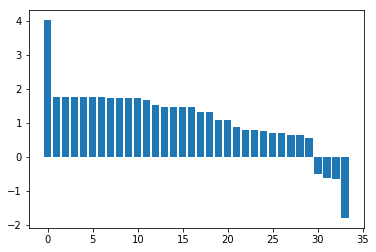

In [26]:
check_missingrate_df = pd.DataFrame.from_dict(check_missingrate, orient='index')
check_missingrate_df['log_odds'] = check_missingrate_df.apply(lambda x: np.log(x[1] / x[0]), axis = 1)
check_missingrate_df_sorted = check_missingrate_df.sort_values(by='log_odds', ascending=False)
check_missingrate_df_sorted.columns = ['fraud_rate_nonmissing', 'fraud_rate_missing','log_odds']
plt.bar(x = range(check_missingrate_df_sorted.shape[0]), height = check_missingrate_df_sorted.log_odds)

当log odds显著地不等亍0，说明缺失对亍欺诈是存在一定的影响的。  
### 从有图中可以发现，所有存在缺失的变量，缺失值对亍欺诈的影响都是显著地。因此我们需要区别对待缺失不非缺失。

In [32]:
train_data[['area1_danger','registered_channels','sex','is_email_acct','area8_danger','area6_danger','area11_danger']].head()

,area1_danger,registered_channels,sex,is_email_acct,area8_danger,area6_danger,area11_danger
34679,5.0,PC,2.0,0.0,1.0,4,4
30551,5.0,SDK,2.0,0.0,2.0,5,5
7462,5.0,NaN,NaN,NaN,4.0,5,4
29711,5.0,PC,2.0,0.0,1.0,5,3
4180,5.0,NaN,NaN,NaN,3.0,3,5


### 如何判断一个变量是否是类别型变量？

In [40]:
pd.get_dummies(train_data.loc[:, 'registered_channels'], prefix='registered_channels').head()

,registered_channels_31,registered_channels_ANDROID,registered_channels_APP,registered_channels_IOS,registered_channels_PC,registered_channels_SDK,registered_channels_WAP
34679,0,0,0,0,1,0,0
30551,0,0,0,0,0,1,0
7462,0,0,0,0,0,0,0
29711,0,0,0,0,1,0,0
4180,0,0,0,0,0,0,0


In [41]:
### 对于类别型变量，需要将缺失看做单独的状态,然后进行哑变量编码，并删除原始变量 ###
categorical_cols_withmissing = ['area1_danger','registered_channels','sex','is_email_acct','area8_danger','area6_danger','area11_danger']
dummy_columns = []
for raw_col in categorical_cols_withmissing:
    dummies = pd.get_dummies(train_data.loc[:, raw_col], prefix=raw_col)
    train_data = pd.concat([train_data, dummies], axis=1)
    dummies = pd.get_dummies(test_data.loc[:, raw_col], prefix=raw_col)
    test_data = pd.concat([test_data, dummies], axis=1)
    del train_data[raw_col]
    del test_data[raw_col]
    dummy_columns.append(list(dummies.columns))

In [42]:
#对于数值型变量，可以将原始变量与表示缺失状态的示性变量交互地使用.此外，由于这些变量都是非负数，对于缺失，可以用0来填补
continuous_cols_withmissing = [i for i in columns_with_missing if i not in categorical_cols_withmissing]
for col in continuous_cols_withmissing:
    train_data[col+'_ismissing']  = train_data[col].map(lambda x: int(x!=x))
    train_data[col] = MakeupM_Missing(train_data, col, 0)
    test_data[col+'_ismissing']  = test_data[col].map(lambda x: int(x!=x))
    test_data[col] = MakeupM_Missing(test_data, col, 0)

#注意到，原始数据中，年龄age没有缺失值，但是有0.需要将0看成缺失
train_data['age'+'_ismissing']  = train_data['age'].map(lambda x: int(x==0))
test_data['age'+'_ismissing']  = test_data['age'].map(lambda x: int(x==0))

In [43]:
train_data.columns

Index(['ID', 'certificationtype', 'age', 'registered_days', 'area4_danger',
       'is_area3_eqaul_area4', 'is_area3_equal_area6', 'is_area4_equal_area6',
       'is_area7_equal_area3', 'is_area7_equal_area4',
       ...
       '12h_sign_bank_cnt_ismissing', '30d_Min_pay_amount_ismissing',
       '30d_Max_pay_amount_ismissing', '30d_Sum_pay_amount_ismissing',
       '30d_pay_times_ismissing', '60d_Sum_pay_amount_ismissing',
       '60d_pay_times_ismissing', '90days_sign_bank_cnt_ismissing',
       '30days_sign_bank_cnt_ismissing', 'age_ismissing'],
      dtype='object', length=132)

In [44]:
#######################
####  3，特征衍生  #####
#######################
#（1）构造平均值型变量
periods = ['10m','30m','1h','12h','1d','7d','15d','30d','60d','90d']
for period in periods:
    amount = period+'_Sum_pay_amount'
    times = period+'_pay_times'
    avg_payment = period+'_Avg_pay_amount'
    train_data[avg_payment] = train_data[[amount,times]].apply(lambda x: Avg_Calc(x[amount],x[times]),axis=1)
    test_data[avg_payment] = test_data[[amount,times]].apply(lambda x: Avg_Calc(x[amount],x[times]),axis=1)

#（2）构造变量，检查平均每次支付金额上升量
for i in range(len(periods)-1):
    avg_payment_1 = periods[i]+'_Avg_pay_amount'
    avg_payment_2 = periods[i+1] + '_Avg_pay_amount'
    increase_payment = periods[i] + '_' + periods[i+1] + '_payment_increase'
    train_data[increase_payment] = train_data[[avg_payment_1,avg_payment_2]].apply(lambda x: x[avg_payment_1] - x[avg_payment_2],axis=1)
    test_data[increase_payment] = test_data[[avg_payment_1,avg_payment_2]].apply(lambda x: x[avg_payment_1] - x[avg_payment_2],axis=1)


#（3）在（1）的基础上求最大的平均支付金额值
avg_payments = [d+'_Avg_pay_amount' for d in periods]
train_data['max_Avg_pay_amount'] = train_data[avg_payments].apply(lambda x: max(x),axis=1)
test_data['max_Avg_pay_amount'] = test_data[avg_payments].apply(lambda x: max(x),axis=1)

In [21]:
######################################
####  4，特征极端值分析与归一化处理  #####
######################################
all_columns = sorted(list(train_data.columns))
outlier_columns = ['10m_30m_payment_increase','10m_Avg_pay_amount','10m_pay_times','10m_Sum_pay_amount','12h_1d_payment_increase','12h_Avg_pay_amount',
                   '12h_pay_times','12h_release_bank_cnt','12h_sign_bank_cnt','12h_Sum_pay_amount','15d_30d_payment_increase','15d_Avg_pay_amount','15d_Max_pay_amount',
                   '15d_Min_pay_amount','15d_pay_times','15d_Sum_pay_amount','1d_7d_payment_increase','1d_Avg_pay_amount','1d_pay_times',
                   '1d_Sum_pay_amount','1h_12h_payment_increase','1h_Avg_pay_amount','1h_pay_times','1h_Sum_pay_amount','30d_60d_payment_increase','30d_Avg_pay_amount',
                   '30d_Max_pay_amount','30d_Min_pay_amount','30d_pay_times','30d_Sum_pay_amount','30days_sign_bank_cnt','30m_1h_payment_increase','30m_Avg_pay_amount',
                   '30m_pay_times','30m_Sum_pay_amount','60d_90d_payment_increase','60d_Avg_pay_amount','60d_Max_pay_amount','60d_Min_pay_amount','60d_pay_times','60d_Sum_pay_amount',
                   '7d_15d_payment_increase','7d_Avg_pay_amount','7d_Max_pay_amount','7d_Min_pay_amount','7d_pay_times','7d_pay_times_ismissing','7d_Sum_pay_amount',
                   '90d_Avg_pay_amount','90d_Max_pay_amount','90d_Min_pay_amount','90d_pay_times','90d_Sum_pay_amount','90days_sign_bank_cnt','max_Avg_pay_amount','pay_amount',
                   'registered_days']

outlier_fraud = {}
for col in outlier_columns:
    temp_df = train_data[[col,'flag']]
    outlier_fraud[col] = Outlier_Effect(temp_df, col, 'flag')
outlier_fraud_df = pd.DataFrame.from_dict(outlier_fraud, orient='index')
outlier_fraud_df.columns = ['log_odds_lower','log_odds_upper']


#由于本案例中极端值对欺诈概率无显著影响，故可以直接对特征做归一化处理
#我们使用均值-标准差归一化方法，且需平滑异常值

lower, upper, mu, sigma = {}, {}, {}, {}
for col in outlier_columns:
    temp_df = train_data[[col,'flag']]
    zero_score = Zero_Score_Normalization(temp_df,col)
    train_data[col] = zero_score['new_var']
    lower[col], upper[col], mu[col], sigma[col] =zero_score['lower'], zero_score['upper'], zero_score['mu'], zero_score['sigma']
    test_data[col] =  test_data[col].map(lambda x: (x-mu[col])/sigma[col])

C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


In [22]:
########################################
####  5，构建基于Ridge的逻辑回归模型  #####
########################################
all_features = list(train_data.columns)
all_features.remove('ID')
all_features.remove('flag')


#对于参数C的选择，我们用交叉验证法选择最优的C
C_list = np.arange(0.01,1,0.01)
auc = []
for c in C_list:
    train2, validation = model_selection.train_test_split(train_data, test_size=0.2)
    LR = LogisticRegression(C=c).fit(train2[all_features], train2['flag'])
    pred = LR.predict_proba(validation[all_features])[:,1]
    test_auc = metrics.roc_auc_score(validation['flag'], pred)
    auc.append(test_auc)

position = auc.index(max(auc))
C_best = C_list[position]
print(max(auc))


LR = LogisticRegression(C=C_best).fit(train_data[all_features], train_data['flag'])
pred = LR.predict_proba(train_data[all_features])

0.9458470169677065


In [29]:
pred1 = LR.predict_proba(test_data[all_features])[:,1]
metrics.roc_auc_score(test_data['flag'], pred1)

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.9077334013538325

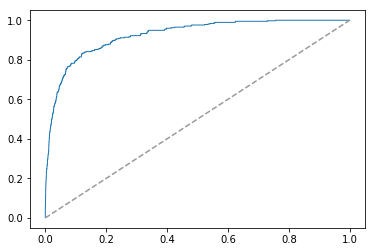

In [31]:
####画ROC曲线
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

fpr, tpr, thresholds = roc_curve(train_data['flag'], pred[:, 1])
mean_tpr += interp(mean_fpr, fpr, tpr)          #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数
mean_tpr[0] = 0.0                               #初始处为0
#roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
#plt.title('AUC=%0.2f'%(roc_auc))

##### 在测试集上测试模型的性能:0.9077334013538325